In [1]:
import numpy as np
import numpy.linalg as nl
import scipy.optimize as so
import scipy.linalg as sl
import scipy.integrate as si
import matplotlib.pyplot as plt
from numba import njit

In [2]:
@njit
def toeplitz(r, c):
    c = np.asarray(c).ravel()
    r = np.asarray(r).ravel()
    # Form a 1-D array containing a reversed c followed by r[1:] that could be
    # strided to give us toeplitz matrix.
    vals = np.concatenate((c[::-1], r[1:]))
    out_shp = len(c), len(r)
    n = vals.strides[0]
    return np.lib.stride_tricks.as_strided(vals[len(c)-1:], shape=out_shp, strides=(-n, n)).copy()

<h3>Forward Problem</h3>

In [3]:
# set number of basis functions to use
# for Fourier representation
nmax = 128

# set size of spatial domain
L = 16

In [4]:
# test potentials for generating synthetic observations

# symmetric double well potential
#def v(x):
#    return 0.25*(x**2 - 25)**2

# dimensionless quantum harmonic oscillator potential
def v(x):
    return 0.5*x**2

In [5]:
# this code transforms the potential function to the fourier basis
# and then forms the potential matrix

# set sampling rate
# if f_sample = 2*nmax, then we are sampling at the Nyquist frequency
# scaling the Nyquist frequency reduces resolution but uses less memory
f_sample = 100 * 2 * nmax

# create vector of time step points
t = np.linspace(-L, L, f_sample+2, endpoint=False)

# sample the potential at times t, do FFT for real input
# (normalizing on the forward transform),
# and take the first 2*nmax+1 coefficents
y = np.fft.rfft(v(t), norm="forward")[:(2*nmax+1)]

# store the Fourier series coefficients for n-m=0,...,2*nmax
# WHY DO WE MULTIPLY BY -1^(n-m)?
vrow = y * (-1)**np.arange(2*nmax+1)

# construct potential matrix
vmat = toeplitz(r=vrow,c=np.conj(vrow))

In [5]:
# this code constructions the Hamiltonian matrix
# and diagonalizes it, this is then used to propagate the system

# construct kinetic matrix
kmat = np.diag(np.arange(-nmax,nmax+1)**2 * np.pi**2 / (2*L**2))

# construct Hamiltonian matrix
hmat = kmat + vmat

# check if the Hamiltonian matrix is Hermitian
print(nl.norm(hmat - hmat.T.conj()))

# diagonalize hmat matrix (i.e. eigendecomposition)
# eigenspectrum / eigensates
eigval, eigsta = nl.eigh(hmat)

# check if eigval / eigsta diagonalizes hmat
# if this is close to zero then
# hmat = states @ np.diag(spec) @ np.conj(states).T
print(nl.norm(hmat @ eigsta - eigsta @ np.diag(eigval)))

# check if the eigenstates are unitary
print(nl.norm(eigsta @ eigsta.T.conj() - np.eye(2*nmax+1)))

0.0
5.72003711317733e-12
4.07668687362199e-14


In [6]:
# this code constructs elements needed for plotting and
# converting from the Fourier basis to real space

# create vector of real space points
xvec = np.linspace(-L, L, 1025)

# construct matrix to convert basis coefficients into real space values
nvec = np.arange(-nmax, nmax+1) # nvec=-nmax,...,0,...,nmax
convmat = np.exp(1j * np.pi * np.outer(nvec, xvec) / L) / np.sqrt(2*L)

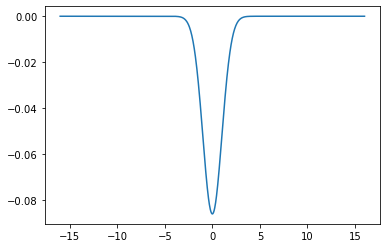

1.0000000000000018


In [7]:
# this code plots the ground state wave function of hmat

wavefn = eigsta[:, 0] @ convmat
plt.plot(xvec, -wavefn.real)
plt.show()

# check if the normalization of the wave function is 1
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))

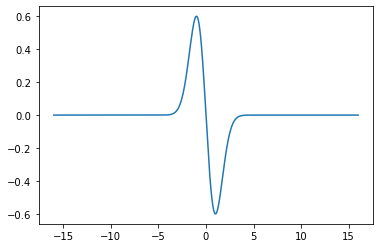

0.9999999999999993


In [8]:
# this code plots the first excited state of hmat

wavefn = eigsta[:, 1] @ convmat
plt.plot(xvec, -wavefn.real)
plt.show()

# check if the normalization of the wave function is 1
print(np.sum(np.abs(wavefn)**2 * (xvec[1]-xvec[0])))

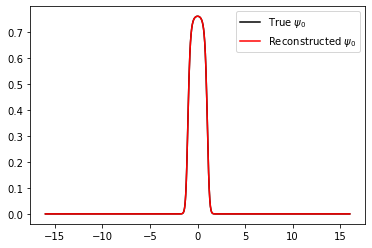

In [9]:
# this code creates the initial wave function psi0

# triangular pulse
# def psi0(x):
#     return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - np.abs(x)), 0])

# parabolic pulse
# def psi0(x):
#     return np.piecewise(x, [x < -1, (x >= -1) & (x <= 1), x > 1], [0, lambda x: (1 - x**2), 0])

# hyperbolic secant squared
# def psi0(x):
#     return (np.cosh(x))**(-2)

# Laplace
# def psi0(x):
#     return np.exp(-np.abs(x))

# rounded box function
def psi0(x):
    return 1.0 + np.tanh((1 - x**2)/0.5)

# normalize psi0
norm = np.sqrt(si.quad(lambda x: np.abs(psi0(x))**2, a=-L, b=L)[0])
def normpsi0(x):
    return psi0(x)/norm

# transform psi0 to Fourier basis using quadrature method
# do this by stepping through and integrating for each n
vraw = np.zeros(nmax+1, dtype=np.complex128)
for thisn in range(nmax+1):
    def integ(x):
        return (2*L)**(-0.5)*np.exp(-1j*np.pi*thisn*x/L)*normpsi0(x)
    def rinteg(x):
        return np.real(integ(x))
    def iinteg(x):
        return np.imag(integ(x))
    vraw[thisn] = si.quad(rinteg, a=-L, b=L)[0] + 1j*si.quad(iinteg, a=-L, b=L)[0]
ainit = np.concatenate([np.conjugate(np.flipud(vraw[1:])), vraw])

# check if the reconstructed psi0 is "close enough" to the
# actual psi0
plt.plot(xvec, normpsi0(xvec), color='black', label=r"True $\psi_0$")
psi0recon = np.real(ainit @ convmat)
plt.plot(xvec, psi0recon, color='red', label=r"Reconstructed $\psi_0$")
plt.legend()
plt.show()

<h3>Inverse Problem</h3>

In [10]:
# set the time step size for propagating
dt = 0.01

# set the number of steps to propagate "a" vector in time
nsteps = 200


**Generate Training Data**

In [11]:
# this code generates the training data by propagating the "a" vector
# of coefficients using the eigendecomposition from above

# compute the propagator matrix using eigval & eigsta
propmat = eigsta @ np.diag(np.exp(-1j * eigval * dt)) @ eigsta.T.conj()

# initialize matrix to store time series data for "a" vector 
amat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
amat[0, :] = ainit.copy()

# propagate "a" vector using propmat
for j in range(nsteps):
    amat[j+1,:] = propmat @ amat[j,:]
    
# transform amat to real space
psimat = np.abs(amat @ convmat)**2

# check that wave function is normalized for every time step
psimatnorm = np.sqrt(np.sum(np.abs(amat)**2, axis=1))
print(psimatnorm)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1.]


**Code for Propagating $\hat{a}$ Vector**

In [12]:
# this code propagates the a/ahat vector using a Hamiltonian which
# depends on the modeling paramters theta/thetahat

@njit
def prop(x):
    m = 2*nmax + 1
    
    # generate vhatmat from model paramters thetahat
    thetahatR = x[:m]
    thetahatI = np.copy(x[(m-1):])
    thetahatI[0] = 0.0
    thetahat = thetahatR + 1j*thetahatI
    vhatmat = toeplitz(r=thetahat,c=np.conj(thetahat))

    # Hamiltonian matrix 
    hhatmat = kmat + vhatmat

    # eigendecomposition and compute propagator
    hatspec, hatstates = np.linalg.eigh(hhatmat)
    hatprop = hatstates @ np.diag(np.exp(-1j*hatspec*dt)) @ np.conj(hatstates.T)
    hatpropH = hatstates @ np.diag(np.exp(1j*hatspec*dt)) @ np.conj(hatstates.T)

    # propagate the ahat vector of coefficients, i.e., solve the *forward* problem
    ahatmat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
    ahatmat[0,:] = np.copy(ainit)
    for j in range(nsteps):
        ahatmat[j+1,:] = hatprop @ ahatmat[j,:]

    # propagating the lambda vector backward in time, i.e., solve the *adjoint* problem
    lambmat = np.zeros((nsteps+1, 2*nmax+1), dtype=np.complex128)
    lambmat[nsteps,:] = ahatmat[nsteps,:] - amat[nsteps,:]
    for j in range(nsteps-1,0,-1):
        lambmat[j,:] = ahatmat[j,:] - amat[j,:] + hatpropH @ lambmat[j+1,:]
    
    return hatspec, hatstates, ahatmat, lambmat, hatprop, hatpropH


In [13]:
# compute the Lagrangian
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def laghelp(x, ahatmat):
    # compute lagrangian
    resid = ahatmat - amat
    lag = 0.5*np.real(np.sum(np.conj(resid)*resid))
    return lag

laghistlen = 20
laghist = np.zeros(laghistlen)
itercnt = 0

def justlag(x):
    global laghist, laghistpsn
    global glbhatspec, glbhatstates, glbahatmat, glblambmat
    global glbhatprop, glbhatpropH
    global itercnt
    
    # propagate system
    glbhatspec, glbhatstates, glbahatmat, glblambmat, glbhatprop, glbhatpropH = prop(x)
    
    # compute Lagrange
    lag = laghelp(x, glbahatmat)
    itercnt += 1
    
    # roll the history back one and replace with newest value
    # i.e. put newest value on the end of the stack
    laghist = np.roll(laghist, -1)
    laghist[-1] = lag
    
    # print the last 5 values of laghist
    print(f'{itercnt} Lagrangan={laghist[-5:]}', end='\r')
    return lag
    

In [14]:
# compute the gradients
# the input x is the vector of modeling parameters (theta or thetahat)

@njit
def gradhelp(x, hatspec, hatstates, ahatmat, lambmat, derivamat):
    m = 2*nmax + 1
    
    alldmat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    expspec = np.exp(-1j*dt*hatspec)
    mask = np.zeros((m,m), dtype=np.complex128)
    for ii in range(m):
        for jj in range(m):
            if np.abs(hatspec[ii] - hatspec[jj]) < 1e-8:
                mask[ii,ii] = expspec[ii]
            else:
                mask[ii,jj] = (expspec[ii] - expspec[jj])/(-1j*dt*(hatspec[ii]-hatspec[jj]))
    
    for iii in range(m):
        ctrvec = np.zeros(m, dtype=np.complex128)
        ctrvec[iii] = 1.0
        ctrmat = toeplitz(r=ctrvec, c=np.conj(ctrvec))
        derivamat[iii, :, :] = hatstates.conj().T @ ctrmat @ hatstates
        qmat = derivamat[iii, :, :] * mask
        alldmat[iii,:,:] = -1j*dt* hatstates @ qmat @ hatstates.conj().T
    
    for iii in range(m-1):
        ctrvec = np.zeros(m, dtype=np.complex128)
        ctrvec[iii + 1] = 1.0j
        ctrmat = toeplitz(r=ctrvec, c=np.conj(ctrvec))
        derivamat[m + iii, :, :] = hatstates.conj().T @ ctrmat @ hatstates
        qmat = derivamat[m + iii, :, :] * mask
        alldmat[m + iii,:,:] = -1j*dt* hatstates @ qmat @ hatstates.conj().T

    return alldmat
        
def justgrad(x):
    global glbhatspec, glbhatstates, glbahatmat, glblambmat
    global glballdmat, glbderivamat
    
    m = 2*nmax + 1
    glbderivamat = np.zeros((2*m-1, m, m), dtype=np.complex128)
    
    # compute alldmat
    glballdmat = gradhelp(x, glbhatspec, glbhatstates, glbahatmat, glblambmat, glbderivamat)
    
    # compute all entries of the gradient at once
    gradients = np.real(np.einsum('ij,ajk,ik->a', np.conj(glblambmat[1:,:]), glballdmat, glbahatmat[:-1,:]))
    return gradients

**Check Functions Using True $\theta$**

In [15]:
# Construct the true theta used to generate training data
truethetaR = np.real(vrow)
truethetaI = np.imag(vrow[1:])
xtrue = np.concatenate([truethetaR, truethetaI])
print(xtrue.shape)

(513,)


In [16]:
# check if the Lagrangian of the true theta, xtrue, gives 0
justlag(xtrue)

0.0

In [17]:
# check if the gradient of the Lagrangian is zero for the true theta, xtrue
justgrad(xtrue)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

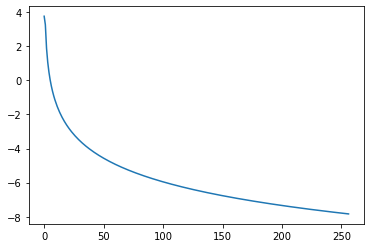

In [18]:
plt.plot(np.arange(2*nmax+1),np.log(np.abs(truethetaR)))
plt.show()

**Initialize theta with true theta pertubed by random normally distributed noise**

In [19]:
# easy test case: initialize theta with true theta pertubed random normally
# distributed noise with small variance. This should be easy for the optimizer
# to converge to a good minimum
xtrub = xtrue.copy()
xtrub += 0.25*np.random.normal(size=xtrue.shape)

In [20]:
laghist = np.zeros(laghistlen)
itercnt = 0
restrub = so.minimize(justlag, xtrub, jac=justgrad,
                  options={'maxiter': 1000}) 

In [20]:
plt.plot(laghist)
plt.show()

[  0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.          38.86125068
 209.00263765  88.29091926  22.47140614 143.07844468  19.90616384]


In [24]:
# check value of Lagrangian at computed value of theta
print(justlag(restrub.x))

# check if computed thetahat is close to true theta
print(nl.norm(restrub.x - np.concatenate([truethetaR, truethetaI])))

0.166072586225284625889457 0.25801507 0.25674508 0.25533671 0.16607259]
80.79914514494094


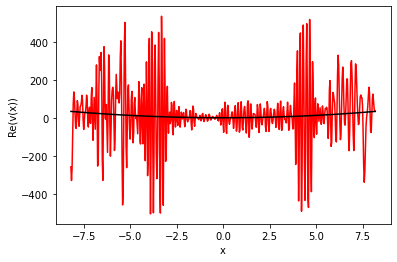

In [25]:
# this code plots the estimated potential against the true potential

mm = 2*nmax+1
thetahat = np.zeros(mm, dtype=np.complex128)
thetahat += restrub.x[:mm]
thetahat[1:] += 1j*restrub.x[mm:]
nvec2 = np.arange(-2*nmax,2*nmax+1)
convmat2 = np.exp(1j*np.pi*np.outer(nvec2, xvec)/L)
fullthetahat = np.concatenate([np.flipud(thetahat[1:].conj()), thetahat])
vx = fullthetahat @ convmat2

# plot the real part of theta
# red = learned potential
# black = true potential
trim = 250
plt.plot(xvec[trim:-trim], np.real(vx)[trim:-trim], color='red')
plt.plot(xvec[trim:-trim], np.real(v(xvec))[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('Re(v(x))')
plt.show()

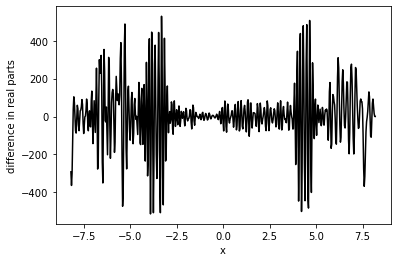

In [26]:
# this code plots the difference between the real part of the estimated potential
# and true potential

trim = 250
plt.plot(xvec[trim:-trim], np.real(vx)[trim:-trim] - np.real(v(xvec))[trim:-trim], color='black')
plt.xlabel('x')
plt.ylabel('difference in real parts')
plt.show()

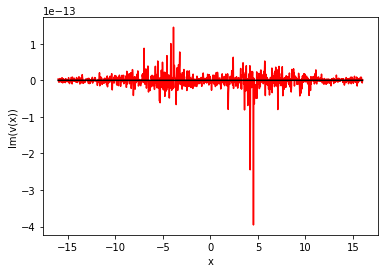

In [27]:
# this code plots the estimated potential against the true potential of the imaginary part

# red = learned potential
# black = true potential
plt.plot(xvec, np.imag(vx), color='red')
plt.plot(xvec, np.imag(v(xvec)), color='black')
plt.xlabel('x')
plt.ylabel('Im(v(x))')
plt.show()

**Initialize theta with uniform random values**

In [21]:
# uniform random values from the interval [-0.5, 0.5]
# this should be difficult for the optimizer to find a good minimum

thetahatR = np.random.uniform(size=2*nmax+1) - 0.5
thetahatI = np.random.uniform(size=2*nmax) - 0.5
xform = np.concatenate([thetahatR, thetahatI])

laghist = np.zeros(laghistlen)
itercnt = 0
resform = so.minimize(justlag, xform, jac=justgrad,
                      method='bfgs', options={'maxiter': 1000})

[0.29184437 0.28959473 0.28668769 0.2838296  0.28010016 0.27745237
 0.27537353 0.27329428 0.27066666 0.2685632  0.26715207 0.26528836
 0.2637096  0.2617865  0.2604245  0.25889457 0.25801507 0.25674508
 0.25533671 0.16607259]


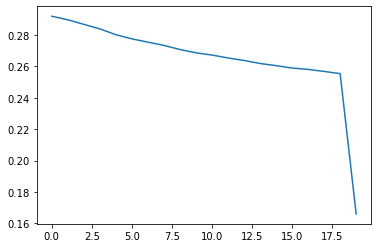

In [31]:
print(laghist)

plt.plot(laghist)
plt.show()

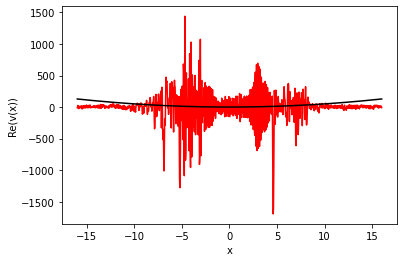

In [33]:
# plot estimated potential

mm = 2*nmax+1
thetahat = np.zeros(mm, dtype=np.complex128)
thetahat += resform.x[:mm]
thetahat[1:] += 1j*resform.x[mm:]
nvec2 = np.arange(-2*nmax,2*nmax+1)
convmat2 = np.exp(1j*np.pi*np.outer(nvec2, xvec)/L)
fullthetahat = np.concatenate([np.flipud(thetahat[1:].conj()), thetahat])
vx = fullthetahat @ convmat2

# plot real part of theta
# red = learned potential
# black = true potential
plt.plot(xvec, np.real(vx), color='red')
plt.plot(xvec, np.real(v(xvec)), color='black')
plt.xlabel('x')
plt.ylabel('Re(v(x))')
plt.show()